<a href="https://colab.research.google.com/github/Existanze54/sirius-neural-networks-2024/blob/main/Practices/03S_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MedMNIST - классификация изображений клеток

В этом семинаре мы поработаем с игрушечным датасетом медицинских изображений - medmnist

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

Пример работы с bloodmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

In [3]:
data_flag = 'bloodmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class']) # same as medmnist.BloodMNIST

In [4]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [5]:
info['python_class']

'BloodMNIST'

In [6]:
medmnist.BloodMNIST

medmnist.dataset.BloodMNIST

In [7]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train',
                          transform=data_transform,
                          download=download)
test_dataset = DataClass(split='test',
                         transform=data_transform,
                         download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset,
                                       batch_size=2*BATCH_SIZE,
                                       shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset,
                              batch_size=2*BATCH_SIZE,
                              shuffle=False)

100%|██████████| 35461855/35461855 [00:02<00:00, 16312500.13it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


/usr/local/lib/python3.10/dist-packages/medmnist/utils.py:32: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


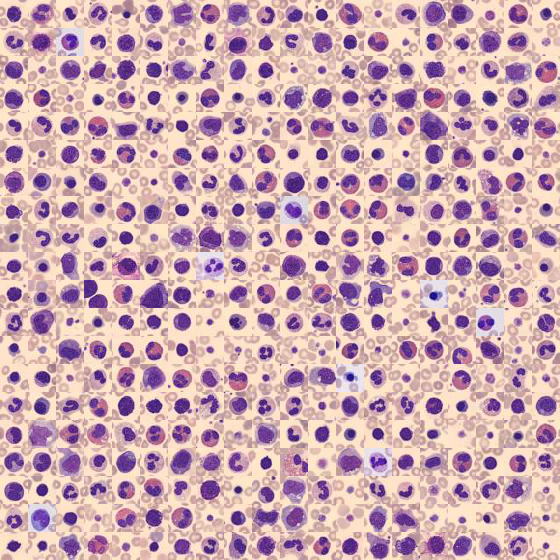

In [8]:
train_dataset.montage(length=20)

In [9]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: CC B

Небольшой пример работы сверточного слоя с 3 входными и 2 выходными каналами.

<img src="https://i.stack.imgur.com/uwHol.gif" width="800">

In [ ]:
pil_dataset[0]

(<PIL.Image.Image image mode=RGB size=28x28>, array([7]))

In [ ]:
pil_dataset[0][0]

In [ ]:
pil_dataset[0][1]

array([7])

In [ ]:
train_dataset[0]

(tensor([[[0.9608, 1.0000, 0.9686,  ..., 1.0000, 0.9686, 1.0000],
          [1.0000, 1.0000, 0.9137,  ..., 0.9922, 0.9922, 1.0000],
          [1.0000, 1.0000, 0.8667,  ..., 1.0000, 0.9686, 1.0000],
          ...,
          [0.8275, 0.8745, 0.9216,  ..., 1.0000, 1.0000, 1.0000],
          [0.6863, 0.7098, 0.7882,  ..., 1.0000, 0.9922, 1.0000],
          [0.7020, 0.6627, 0.6706,  ..., 0.9922, 1.0000, 1.0000]],
 
         [[0.7490, 0.7961, 0.7412,  ..., 0.8667, 0.8039, 0.8353],
          [0.7961, 0.7961, 0.6863,  ..., 0.8196, 0.8275, 0.8980],
          [0.8118, 0.7804, 0.6471,  ..., 0.8275, 0.7961, 0.8980],
          ...,
          [0.6000, 0.6471, 0.7098,  ..., 0.7647, 0.7725, 0.7882],
          [0.4431, 0.4745, 0.5529,  ..., 0.7647, 0.7804, 0.7882],
          [0.4275, 0.4118, 0.4196,  ..., 0.7725, 0.7804, 0.7882]],
 
         [[0.6157, 0.6627, 0.6157,  ..., 0.5294, 0.4510, 0.4980],
          [0.6471, 0.6471, 0.5608,  ..., 0.5137, 0.4902, 0.5765],
          [0.6314, 0.6078, 0.4824,  ...,

In [10]:
for X, y in train_loader:
  break

In [11]:
X.shape, y.shape

(torch.Size([128, 3, 28, 28]), torch.Size([128, 1]))

In [12]:
# 1 CNN layer

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                  out_channels=64,
                  kernel_size=3,
                  padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes).to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [13]:
model(X).shape

torch.Size([128, 64, 28, 28])

In [14]:
# 4 CNN layers

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                  out_channels=64,
                  kernel_size=7,
                  padding='same'),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                  out_channels=128,
                  kernel_size=7,
                  padding='same'),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                  out_channels=256,
                  kernel_size=7,
                  padding='same'),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                  out_channels=512,
                  kernel_size=7,
                  padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes).to(device)


# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [15]:
model(X).shape

torch.Size([128, 512, 28, 28])

In [16]:
512*28*28

401408

In [17]:
# 4 CNN (with reduced channels) + Linear

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3,
                  out_channels=16,
                  kernel_size=7),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16,
                  out_channels=32,
                  kernel_size=7),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                  out_channels=64,
                  kernel_size=7),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                  out_channels=128,
                  kernel_size=7,
                  stride=2),
            nn.ReLU()
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*2*2, 8)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.linear(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes).to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [18]:
model(X).shape

torch.Size([128, 8])

In [ ]:
512 * 4 # reasonable

2048

In [19]:
model(X[:5])

tensor([[ 4.0887e-02, -4.3429e-03,  3.0708e-03, -1.2161e-02, -2.9506e-02,
         -3.9255e-02,  1.2223e-02, -4.6792e-02],
        [ 4.0718e-02,  1.5430e-05, -5.4737e-03, -1.2539e-02, -2.4295e-02,
         -4.0450e-02,  3.9909e-03, -4.6540e-02],
        [ 3.6276e-02,  3.6345e-03, -2.7378e-03, -8.8118e-03, -2.5212e-02,
         -3.5766e-02,  6.1992e-03, -4.4036e-02],
        [ 3.6442e-02, -5.9568e-03, -7.3983e-03, -8.8184e-03, -2.1167e-02,
         -4.0226e-02,  6.8787e-03, -4.1191e-02],
        [ 4.1191e-02,  2.2326e-05, -2.2852e-03, -1.1765e-02, -2.5563e-02,
         -4.1074e-02,  1.6324e-02, -4.2654e-02]], grad_fn=<AddmmBackward0>)

In [20]:
import torch.nn.functional as F

In [21]:
F.softmax(model(X[:5]), dim=1)

tensor([[0.1314, 0.1256, 0.1265, 0.1246, 0.1225, 0.1213, 0.1277, 0.1204],
        [0.1315, 0.1263, 0.1256, 0.1247, 0.1233, 0.1213, 0.1268, 0.1205],
        [0.1307, 0.1265, 0.1257, 0.1250, 0.1229, 0.1216, 0.1269, 0.1206],
        [0.1309, 0.1255, 0.1253, 0.1251, 0.1236, 0.1213, 0.1271, 0.1211],
        [0.1313, 0.1260, 0.1257, 0.1245, 0.1228, 0.1209, 0.1281, 0.1207]],
       grad_fn=<SoftmaxBackward0>)

In [22]:
sum([0.1314, 0.1256, 0.1265, 0.1246, 0.1225, 0.1213, 0.1277, 0.1204])

1.0

In [23]:
for epoch in range(NUM_EPOCHS):

    model.train()
    for inputs, targets in tqdm(train_loader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 94/94 [00:42<00:00,  2.20it/s]


In [24]:
def test(model, split):

    model.eval()
    y_score = torch.tensor([]).to(device)

    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze()
                outputs = outputs.softmax(dim=-1)

            y_score = torch.cat((y_score, outputs), 0)

        y_score = y_score.cpu().detach().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))


print('==> Evaluating ...')
test(model, 'train')
test(model, 'test')

==> Evaluating ...
train  auc: 0.910  acc:0.620
test  auc: 0.912  acc:0.624


In [42]:
# 7 CNN (with reduced channels) + Linear

class Net(nn.Module):
    def __init__(self, in_channels, num_classes, block_sizes=(16, 32, 64, 128, 256, 512, 1024)):
        super().__init__()

        # # you can add blocks to a nn.Sequential within a loop
        # cnn_blocks = []
        # cnn_blocks.append(nn.Sequential(
        #         nn.Conv2d(in_channels = in_channels,
        #                   out_channels = block_sizes[0],
        #                   kernel_size = 3),
        #         nn.ReLU()
        #         )
        # )
        # for i in range(len(block_sizes) - 1):
        #     cnn_blocks.append(nn.Sequential(
        #         nn.Conv2d(in_channels = block_sizes[i],
        #                   out_channels = block_sizes[i + 1],
        #                   kernel_size = 3),
        #         nn.ReLU()
        #         )
        #     )
        # self.featurizer = nn.Sequential(*cnn_blocks)

        self.featurizer = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(in_channels = 3,
                          out_channels = 16,
                          kernel_size = 3),
                nn.ReLU()
                ),
            nn.Sequential(
                nn.Conv2d(in_channels = 16,
                          out_channels = 32,
                          kernel_size = 3),
                nn.ReLU()
                ),
            nn.Sequential(
                nn.Conv2d(in_channels = 32,
                          out_channels = 64,
                          kernel_size = 3),
                nn.ReLU()
                ),
            nn.Sequential(
                nn.Conv2d(in_channels = 64,
                          out_channels = 128,
                          kernel_size = 3),
                nn.ReLU()
                ),
            nn.Sequential(
                nn.Conv2d(in_channels = 128,
                          out_channels = 256,
                          kernel_size = 3,
                          stride = 2),
                nn.ReLU()
                ),
            nn.Sequential(
                nn.Conv2d(in_channels = 256,
                          out_channels = 512,
                          kernel_size = 3,
                          stride = 2),
                nn.ReLU()
                ),
            nn.Sequential(
                nn.Conv2d(in_channels = 512,
                          out_channels = 1024,
                          kernel_size = 3,
                          stride = 2),
                nn.ReLU()
                )
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 8)
        )

    def forward(self, x):
        x = self.featurizer(x)
        x = self.head(x)
        return x

model = Net(in_channels=n_channels, num_classes=n_classes).to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [43]:
model(X).shape

torch.Size([128, 8])

In [44]:
for epoch in range(NUM_EPOCHS):

    model.train()
    for inputs, targets in tqdm(train_loader):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze()
            loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

100%|██████████| 94/94 [04:11<00:00,  2.67s/it]


In [46]:
print('==> Evaluating ...')
test(model, 'train')
test(model, 'test')

==> Evaluating ...
train  auc: 0.670  acc:0.195
test  auc: 0.675  acc:0.195


Получили качество даже хуже, чем было.

К сожалению, если в нейронные сети добавлять много слоев без дополнительных модификаций, они могут хуже сходиться (обучаться).